<a href="https://colab.research.google.com/github/grrr71/playround/blob/main/order_book_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
### !pip install py_clob_client
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime
import matplotlib.dates as mdates
import requests


from dune_client.client import DuneClient

from py_clob_client.client import ClobClient
from py_clob_client.clob_types import BookParams
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install py_clob_client

In [ ]:
!pip install dune-client

In [12]:
# Assuming you have a client already initialized as 'client'

def fetch_and_append_order_books(asset_ids, save_path):
    while True:
        for asset_id in asset_ids:
            try:
                response = client.get_order_book(asset_id)

                timestamp_ms = int(response.timestamp)
                timestamp_readable = datetime.fromtimestamp(timestamp_ms / 1000).strftime('%Y-%m-%d %H:%M:%S')

                rows = []
                for bid in response.bids:
                    rows.append({
                        'market': response.market,
                        'asset_id': response.asset_id,
                        'timestamp': timestamp_readable,
                        'side': 'bid',
                        'price': bid.price,
                        'size': bid.size
                    })

                for ask in response.asks:
                    rows.append({
                        'market': response.market,
                        'asset_id': response.asset_id,
                        'timestamp': timestamp_readable,
                        'side': 'ask',
                        'price': ask.price,
                        'size': ask.size
                    })

                df = pd.DataFrame(rows)

                file_name = f"{save_path}order_book_{asset_id}_{response.market}.csv"

                # Check if file exists to write header only once
                if not os.path.isfile(file_name):
                    df.to_csv(file_name, index=False, mode='w', header=True)
                else:
                    df.to_csv(file_name, index=False, mode='a', header=False)

                print(f"Appended order book for asset {asset_id} at {timestamp_readable} to {file_name}")

            except Exception as e:
                print(f"Error fetching order book for asset {asset_id}: {e}")

        # Wait 60 seconds before next round
        time.sleep(60)


In [13]:
def load_and_prepare_order_book(save_path, asset_id, market_id):
    """
    Loads and prepares order book data from disk.

    Args:
        save_path (str): Path where the order book CSV is saved.
        asset_id (str): Asset ID used in the file name.
        market_id (str): Market ID used in the file name.

    Returns:
        pd.DataFrame: DataFrame with bids and asks combined, and human-readable timestamp column added.
    """
    file_name = f"{save_path}order_book_{asset_id}_{market_id}.csv"

    if not os.path.exists(file_name):
        raise FileNotFoundError(f"File not found: {file_name}")

    df = pd.read_csv(file_name)

    # Convert UNIX timestamp string to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Add a human-readable timestamp (time of day)
    df['timestamp_human'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Add identifying columns just to be sure
    df['asset_id'] = asset_id
    df['market_id'] = market_id

    return df

In [14]:

def compute_order_book_metrics(df, order_size=5, plot=True):
    """
    Compute order book metrics and optionally generate visualizations.

    Args:
        df (pd.DataFrame): Combined order book DataFrame with 'side', 'price', 'size', and 'timestamp'.
        order_size (float): Size of the hypothetical order for price impact.
        plot (bool): If True, generate plots for the computed metrics.

    Returns:
        pd.DataFrame: DataFrame with metrics computed for each timestamp.
    """

    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['size'] = pd.to_numeric(df['size'], errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    metrics = []

    for timestamp, group in df.groupby('timestamp'):
        bids = group[group['side'] == 'bid'].copy()
        asks = group[group['side'] == 'ask'].copy()

        bids.sort_values('price', ascending=False, inplace=True)
        asks.sort_values('price', ascending=True, inplace=True)

        best_bid = bids.iloc[0]['price'] if not bids.empty else None
        best_ask = asks.iloc[0]['price'] if not asks.empty else None
        spread = (best_ask - best_bid) if (best_bid is not None and best_ask is not None) else None

        total_bid_depth = bids['size'].sum() if not bids.empty else 0
        total_ask_depth = asks['size'].sum() if not asks.empty else 0

        top_bid_depth = bids.iloc[0]['size'] if not bids.empty else 0
        top_ask_depth = asks.iloc[0]['size'] if not asks.empty else 0

        if (top_bid_depth + top_ask_depth) > 0:
            imbalance = (top_bid_depth - top_ask_depth) / (top_bid_depth + top_ask_depth)
        else:
            imbalance = None

        def calculate_price_impact(order_size, book_side):
            cumulative_size = 0
            for idx, row in book_side.iterrows():
                cumulative_size += row['size']
                if cumulative_size >= order_size:
                    return abs(row['price'] - book_side.iloc[0]['price'])
            return None

        buy_price_impact = calculate_price_impact(order_size, asks)
        sell_price_impact = calculate_price_impact(order_size, bids)

        metrics.append({
            'timestamp': timestamp,
            'best_bid': best_bid,
            'best_ask': best_ask,
            'bid_ask_spread': spread,
            'total_bid_depth': total_bid_depth,
            'total_ask_depth': total_ask_depth,
            'top_bid_depth': top_bid_depth,
            'top_ask_depth': top_ask_depth,
            'order_book_imbalance': imbalance,
            f'buy_price_impact_{order_size}': buy_price_impact,
            f'sell_price_impact_{order_size}': sell_price_impact,
        })

    metrics_df = pd.DataFrame(metrics)

    if plot:
        plt.figure(figsize=(14, 16))

        # 1. Bid-Ask Spread
        plt.subplot(5, 1, 1)
        plt.plot(metrics_df['timestamp'], metrics_df['bid_ask_spread'])
        plt.title('Bid-Ask Spread Over Time')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.ylabel('Spread')

        # 2. Market Depth
        plt.subplot(5, 1, 2)
        plt.plot(metrics_df['timestamp'], metrics_df['total_bid_depth'], label='Bid Depth')
        plt.plot(metrics_df['timestamp'], metrics_df['total_ask_depth'], label='Ask Depth')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.title('Market Depth Over Time')
        plt.ylabel('Depth')
        plt.legend()

        # 3. Top-of-Book Depth
        plt.subplot(5, 1, 3)
        plt.plot(metrics_df['timestamp'], metrics_df['top_bid_depth'], label='Top Bid')
        plt.plot(metrics_df['timestamp'], metrics_df['top_ask_depth'], label='Top Ask')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.title('Top-of-Book Depth Over Time')
        plt.ylabel('Depth')
        plt.legend()

        # 4. Order Book Imbalance
        plt.subplot(5, 1, 4)
        plt.plot(metrics_df['timestamp'], metrics_df['order_book_imbalance'])
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.title('Order Book Imbalance Over Time')
        plt.ylabel('Imbalance')

        # 5. Price Impact
        plt.subplot(5, 1, 5)
        plt.plot(metrics_df['timestamp'], metrics_df[f'buy_price_impact_{order_size}'], label=f'Buy Impact ({order_size})')
        plt.plot(metrics_df['timestamp'], metrics_df[f'sell_price_impact_{order_size}'], label=f'Sell Impact ({order_size})')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.title('Price Impact Over Time')
        plt.ylabel('Impact')
        plt.xlabel('Time')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return metrics_df

In [ ]:
#order_book_40512153726140979349962936463141898179437788077397702575621092542561027021417_0x6b24a578e8644f45e49130da20267e466163dc35fee34dd23357a68530d34381

In [15]:
save_path = "/content/drive/MyDrive/data/"
asset_id = "40512153726140979349962936463141898179437788077397702575621092542561027021417"
market_id = "0x6b24a578e8644f45e49130da20267e466163dc35fee34dd23357a68530d34381"

df = load_and_prepare_order_book(save_path, asset_id, market_id)
df.head()

,market,asset_id,timestamp,side,price,size,timestamp_human,market_id
0,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.01,115516.12,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...
1,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.02,225422.00,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...
2,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.04,2996.80,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...
3,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.05,5755.00,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...
4,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.10,83039.21,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...


In [ ]:
df.columns

Index(['market', 'asset_id', 'timestamp', 'side', 'price', 'size',
       'timestamp_human', 'market_id'],
      dtype='object')

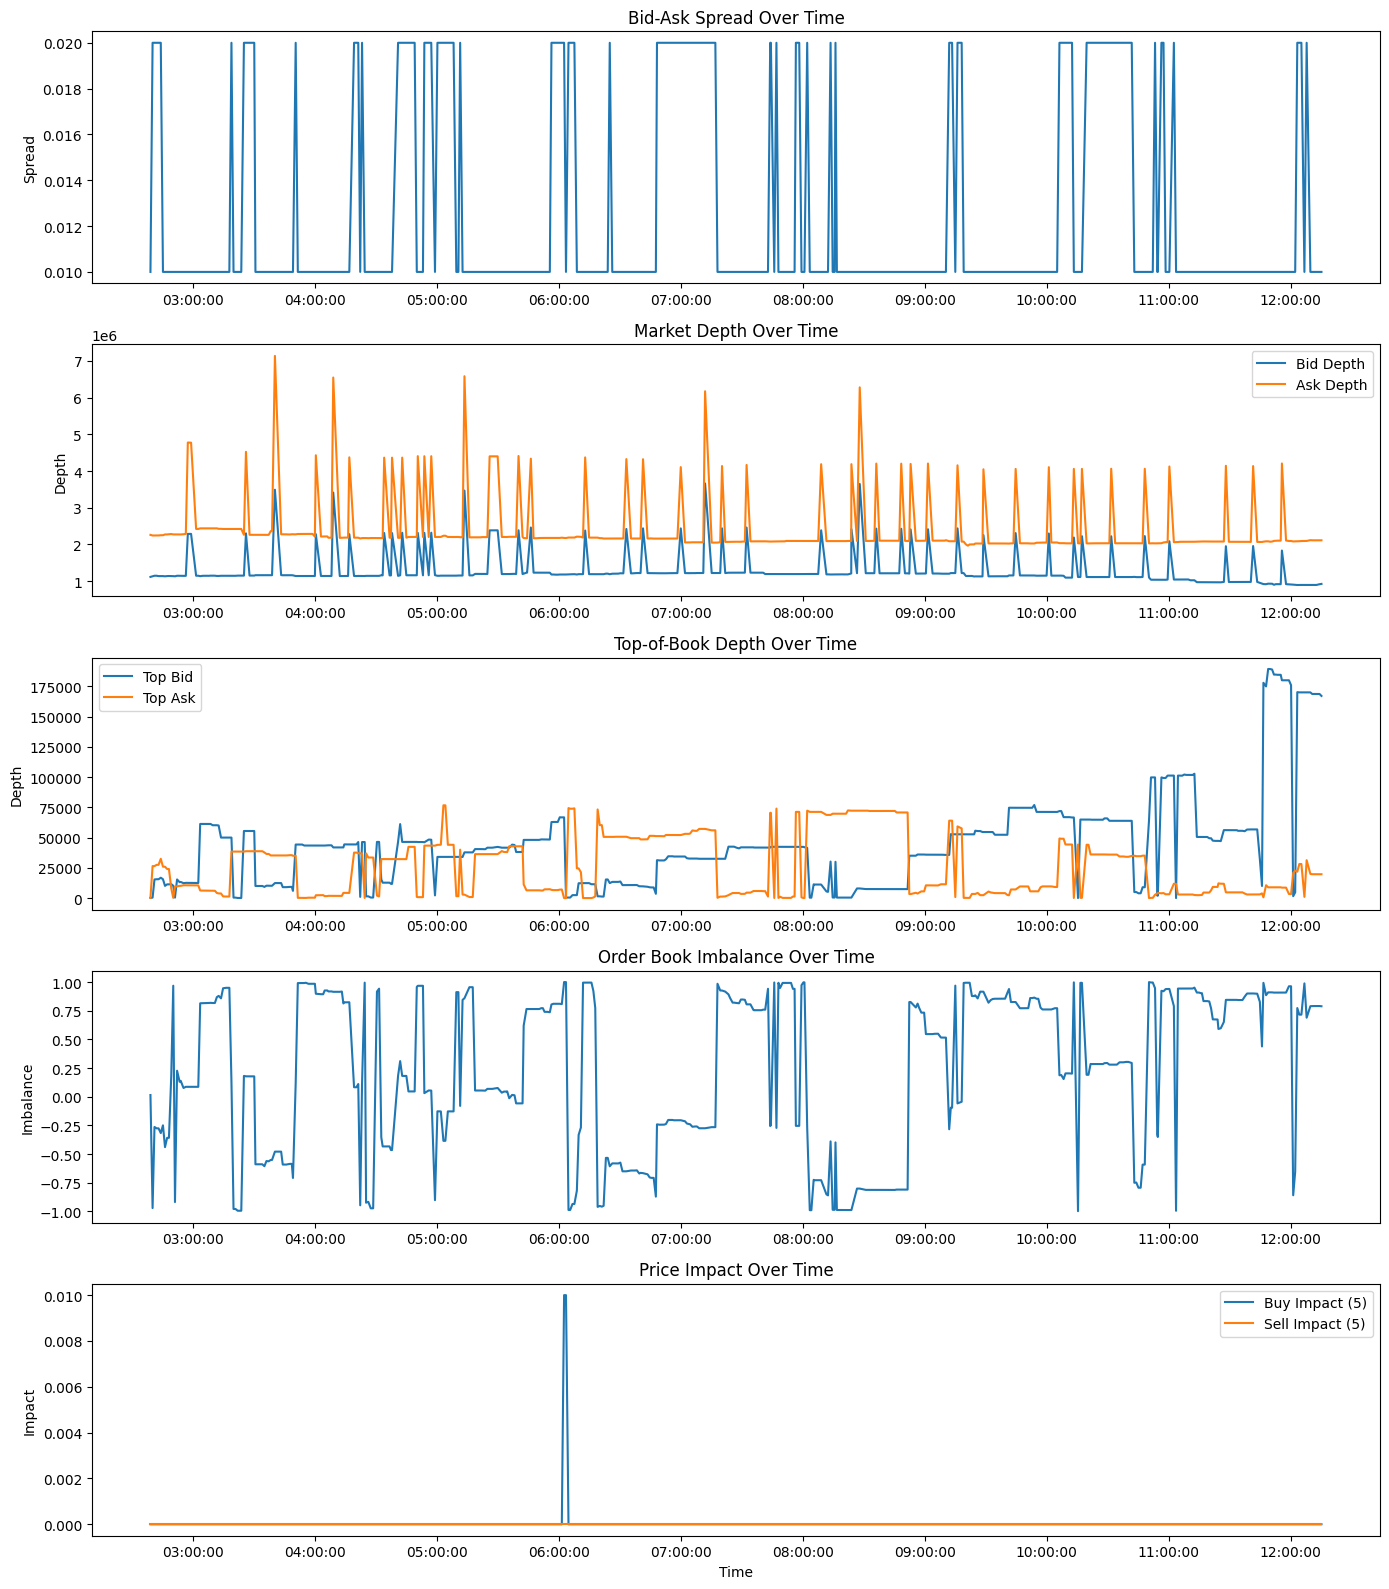

In [ ]:
metrics_df = compute_order_book_metrics(df, order_size=5, plot=True)

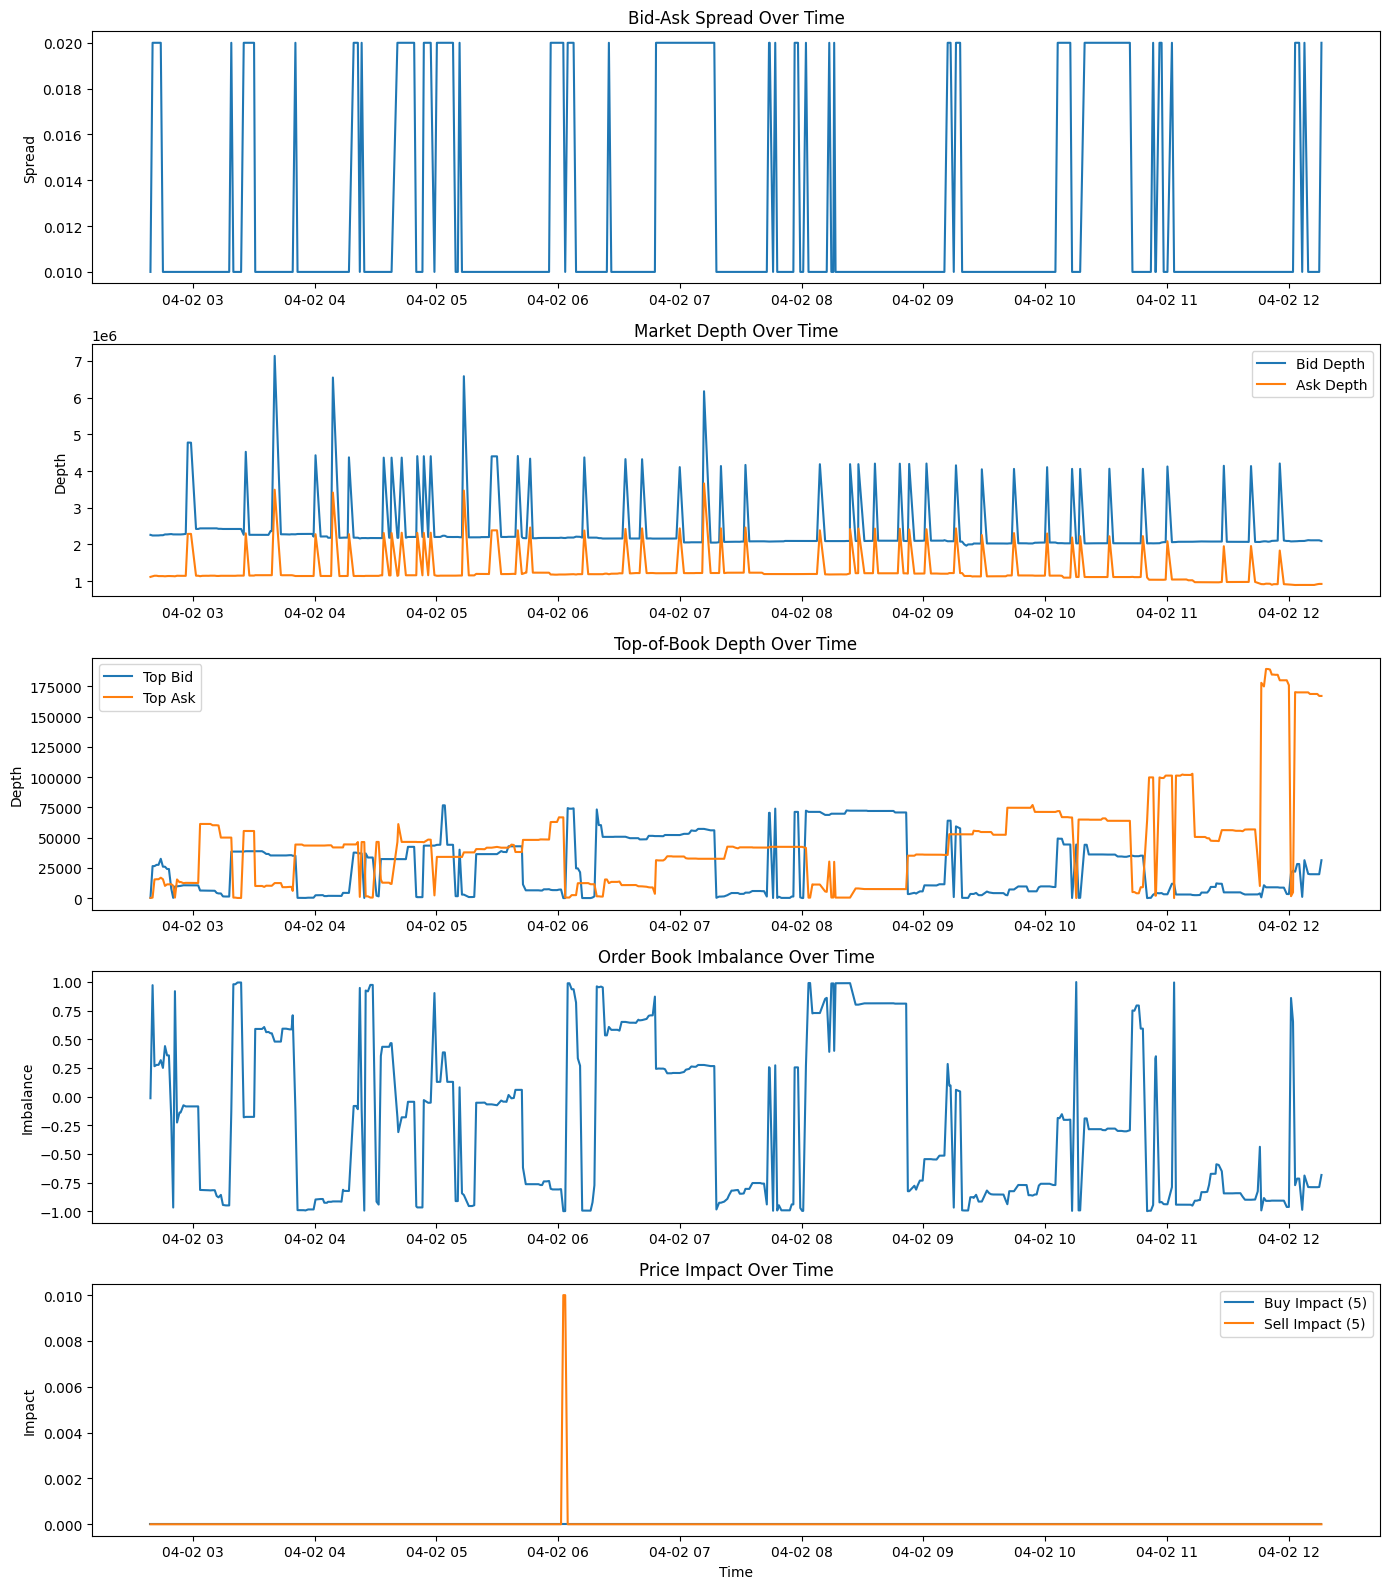

In [ ]:
save_path = "/content/drive/MyDrive/data/"
asset_id = "3485527574732787936912024452124432320769152521602862541331994969625729645537"
market_id = "0x6b24a578e8644f45e49130da20267e466163dc35fee34dd23357a68530d34381"

df = load_and_prepare_order_book(save_path, asset_id, market_id)
metrics_df = compute_order_book_metrics(df, order_size=5, plot=True)

In [5]:
dune_api_key

NameError: name 'dune_api_key' is not defined

In [16]:
dune_api_key = 'CPFSXltZ1gWjP8d8hCHreZPd8BI5GJ90'

In [17]:
url = "https://api.dune.com/api/v1/query/{query_id}/results/csv"

headers = {"X-DUNE-API-KEY": dune_api_key}



In [18]:
response = requests.request("GET", url, headers=headers)

print(response.text)

{"error":"Invalid query ID in URL"}


In [19]:
dune = DuneClient(dune_api_key)
query_result = dune.get_latest_result(4963827)

In [20]:
trades = dune.get_latest_result_dataframe(4963827)

In [21]:
trades.head()

,block_number,block_time,tx_hash,evt_index,action,contract_address,condition_id,event_market_name,question,polymarket_link,...,neg_risk,asset_id,price,amount,shares,fee,maker,taker,unique_key,token_outcome_name
0,69798220.0,2025-04-02 08:26:03.000 UTC,0x641e7cdd916175f1fa0be7e283ea96b48727d06d31cf...,569,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,False,4051215372614097934996293646314189817943778807...,0.410000,0.764406,1.864404,0,0xcfed54e9e04ad3e556bf87a918aac31c71dedf12,0xe47c4106342b732470466dab2455326eef9d6e9a,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...
1,69802370.0,2025-04-02 10:53:05.000 UTC,0x8e282de5f70548396f69ce7fe3472c7f426dee96ac85...,206,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,False,4051215372614097934996293646314189817943778807...,0.400000,70.000000,175.000000,0,0x843a6da3886cf889435cf0920659a00a68db8070,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...
2,69793316.0,2025-04-02 05:32:11.000 UTC,0xf25e1de4fef372b1e5af73970795070f19a7b47b896f...,169,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,False,4051215372614097934996293646314189817943778807...,0.410000,261.170000,637.000000,0,0x15b2a08ee0d4c87b54501f82ef4de2ac9eb62f77,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...
3,69802298.0,2025-04-02 10:50:31.000 UTC,0x486b8686a57684b2f03bc1ec14ac11fe6ef006226316...,403,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,False,4051215372614097934996293646314189817943778807...,0.400000,400.000000,1000.000000,0,0x96e0c92ef3e4e9293a1f64c0ad7b75116ad2b648,0xe2e3c801656a73b2bfd88a41bcf9226d53be67ff,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...
4,69791260.0,2025-04-02 04:19:12.000 UTC,0x02cd9006189081932fc9d18ed109f068584e6e2d3792...,293,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,False,4051215372614097934996293646314189817943778807...,0.401395,1999.999999,4982.621218,0,0xa847eed644251444364e9587086de7e102fa88a5,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...


In [ ]:

# Convert block_time to datetime if not already
trades['block_time'] = pd.to_datetime(trades['block_time'])

# Round timestamps to the nearest minute (you can also use floor or ceil)
trades['minute'] = trades['block_time'].dt.floor('min')

# Ensure numeric types
trades['price'] = pd.to_numeric(trades['price'], errors='coerce')
trades['amount'] = pd.to_numeric(trades['amount'], errors='coerce')
trades = trades.dropna(subset=['price', 'amount'])

In [ ]:
discrete = trades.groupby('minute').agg(
    vwap=('price', lambda x: (x * trades.loc[x.index, 'amount']).sum() / trades.loc[x.index, 'amount'].sum()),
    avg_price=('price', 'mean'),
    total_volume=('amount', 'sum'),
    trade_count=('price', 'count')
).reset_index()

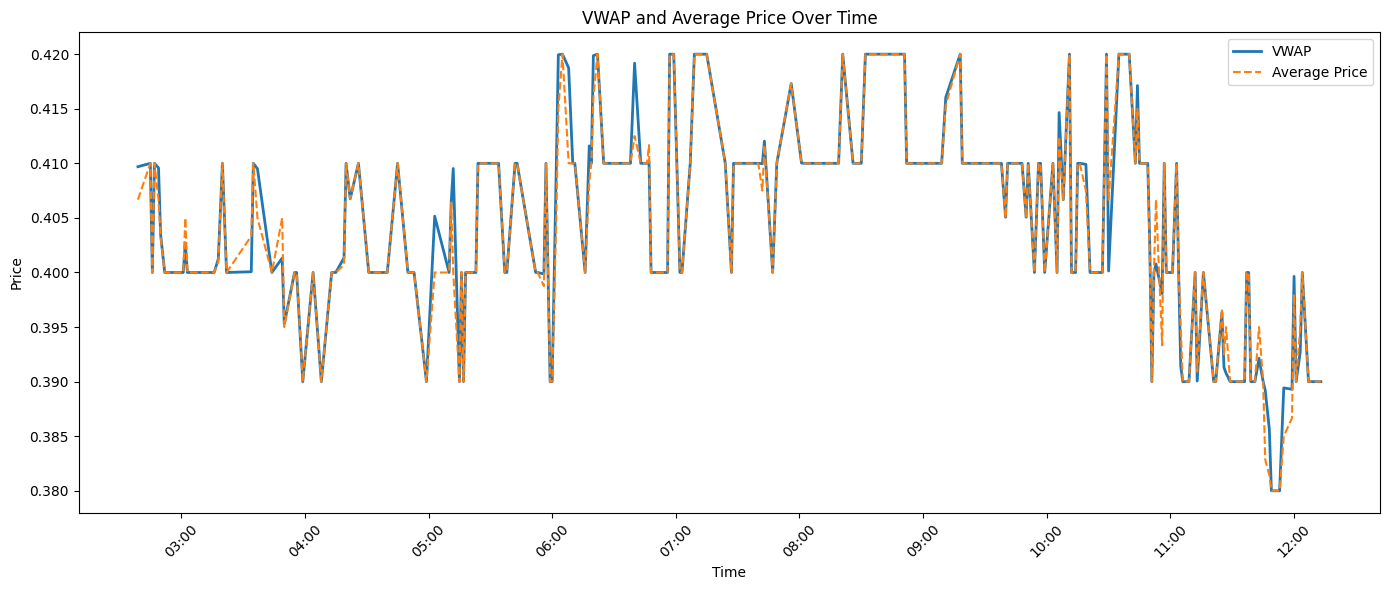

In [ ]:
plt.figure(figsize=(14, 6))

plt.plot(discrete['minute'], discrete['vwap'], label='VWAP', linewidth=2)
plt.plot(discrete['minute'], discrete['avg_price'], label='Average Price', linestyle='--')

plt.title('VWAP and Average Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

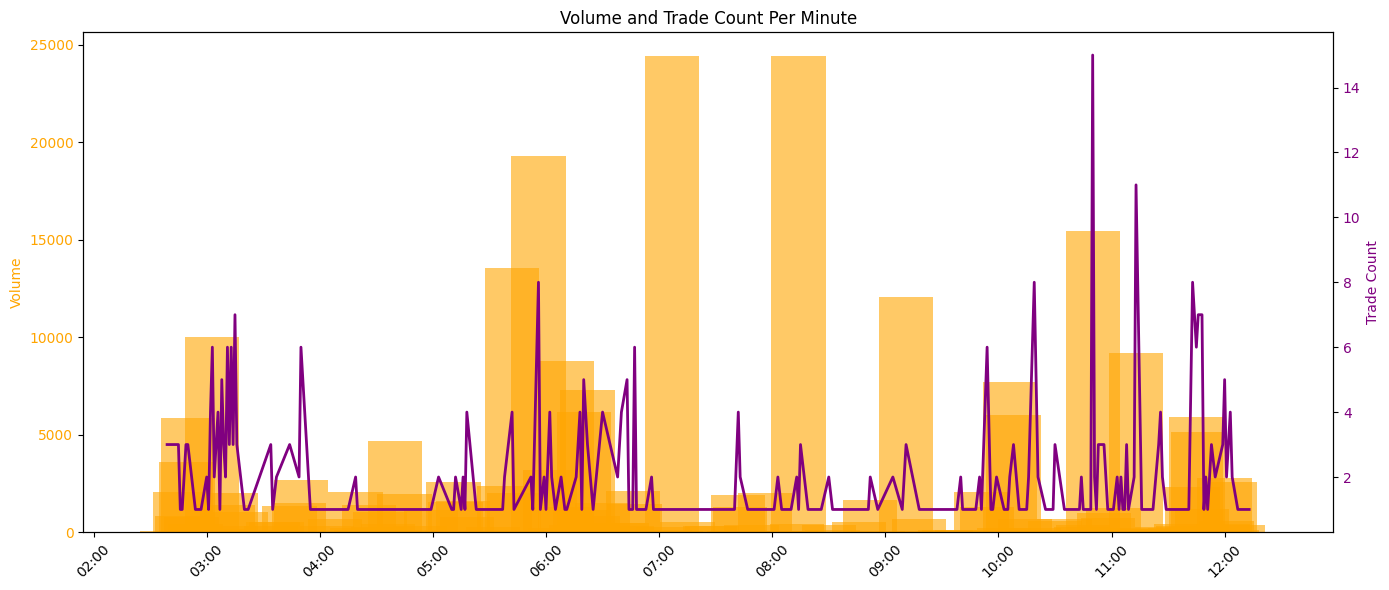

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Volume bar chart (left axis)
ax1.bar(discrete['minute'], discrete['total_volume'], width=0.02, alpha=0.6, label='Total Volume', color='orange')
ax1.set_ylabel('Volume', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Format time
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# Trade count (right axis)
ax2 = ax1.twinx()
ax2.plot(discrete['minute'], discrete['trade_count'], color='purple', label='Trade Count', linewidth=2)
ax2.set_ylabel('Trade Count', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title
plt.title('Volume and Trade Count Per Minute')
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np

In [ ]:
trades['shares'] = pd.to_numeric(trades['shares'], errors='coerce')
trade_data = trades[['minute', 'price', 'amount', 'shares']].dropna()

In [ ]:
trades

,block_number,block_time,tx_hash,evt_index,action,contract_address,condition_id,event_market_name,question,polymarket_link,...,asset_id,price,amount,shares,fee,maker,taker,unique_key,token_outcome_name,minute
0,69798220.0,2025-04-02 08:26:03+00:00,0x641e7cdd916175f1fa0be7e283ea96b48727d06d31cf...,569,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.410000,0.764406,1.864404,0,0xcfed54e9e04ad3e556bf87a918aac31c71dedf12,0xe47c4106342b732470466dab2455326eef9d6e9a,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 08:26:00+00:00
1,69802370.0,2025-04-02 10:53:05+00:00,0x8e282de5f70548396f69ce7fe3472c7f426dee96ac85...,206,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,70.000000,175.000000,0,0x843a6da3886cf889435cf0920659a00a68db8070,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:53:00+00:00
2,69793316.0,2025-04-02 05:32:11+00:00,0xf25e1de4fef372b1e5af73970795070f19a7b47b896f...,169,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.410000,261.170000,637.000000,0,0x15b2a08ee0d4c87b54501f82ef4de2ac9eb62f77,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 05:32:00+00:00
3,69802298.0,2025-04-02 10:50:31+00:00,0x486b8686a57684b2f03bc1ec14ac11fe6ef006226316...,403,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,400.000000,1000.000000,0,0x96e0c92ef3e4e9293a1f64c0ad7b75116ad2b648,0xe2e3c801656a73b2bfd88a41bcf9226d53be67ff,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:50:00+00:00
4,69791260.0,2025-04-02 04:19:12+00:00,0x02cd9006189081932fc9d18ed109f068584e6e2d3792...,293,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.401395,1999.999999,4982.621218,0,0xa847eed644251444364e9587086de7e102fa88a5,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 04:19:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,69801106.0,2025-04-02 10:08:19+00:00,0xb12e0be44b7cf351c6be9e261e8196873519d0b00513...,575,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,2000.000000,5000.000000,0,0xa0e72c4d3d779078f6bd7bd2670ecdc1829bef20,0x0c8f308a923218bb83ee2c5d6aebfaeeaefe44f0,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:08:00+00:00
455,69794674.0,2025-04-02 06:20:21+00:00,0xd165

In [ ]:
# Convert timestamps and discretize by minute
df['timestamp'] = pd.to_datetime(df['timestamp_human'])
df['minute'] = df['timestamp'].dt.floor('min')

trades['block_time'] = pd.to_datetime(trades['block_time'])
trades['minute'] = trades['block_time'].dt.floor('min')

# Ensure numeric types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')
trades['price'] = pd.to_numeric(trades['price'], errors='coerce')
trades['amount'] = pd.to_numeric(trades['amount'], errors='coerce')
trades['shares'] = pd.to_numeric(trades['shares'], errors='coerce')  # ✅ New line for shares

# Drop NA and filter required columns
order_book = df[['minute', 'side', 'price', 'size']].dropna()
trade_data = trades[['minute', 'price', 'amount', 'shares']].dropna()  # ✅ Includes shares

# Remove timezones for merging
order_book['minute'] = order_book['minute'].dt.tz_localize(None)
trade_data['minute'] = trade_data['minute'].dt.tz_localize(None)

# --- Function to compute metrics ---
def compute_single_market_metrics(order_book, trade_data, order_size=5):
    metrics = []

    for minute, group in order_book.groupby('minute'):
        bids = group[group['side'] == 'bid'].sort_values('price', ascending=False)
        asks = group[group['side'] == 'ask'].sort_values('price', ascending=True)

        best_bid = bids['price'].iloc[0] if not bids.empty else np.nan
        best_ask = asks['price'].iloc[0] if not asks.empty else np.nan
        spread = best_ask - best_bid if pd.notna(best_bid) and pd.notna(best_ask) else np.nan

        total_bid_depth = bids['size'].sum()
        total_ask_depth = asks['size'].sum()

        top_bid_depth = bids['size'].iloc[0] if not bids.empty else 0
        top_ask_depth = asks['size'].iloc[0] if not asks.empty else 0

        imbalance = (top_bid_depth - top_ask_depth) / (top_bid_depth + top_ask_depth) if (top_bid_depth + top_ask_depth) > 0 else np.nan

        def price_impact(book_side):
            cumulative = 0
            for _, row in book_side.iterrows():
                cumulative += row['size']
                if cumulative >= order_size:
                    return abs(row['price'] - book_side.iloc[0]['price'])
            return np.nan

        buy_impact = price_impact(asks)
        sell_impact = price_impact(bids)

        metrics.append({
            'minute': minute,
            'best_bid': best_bid,
            'best_ask': best_ask,
            'bid_ask_spread': spread,
            'total_bid_depth': total_bid_depth,
            'total_ask_depth': total_ask_depth,
            'top_bid_depth': top_bid_depth,
            'top_ask_depth': top_ask_depth,
            'order_book_imbalance': imbalance,
            f'buy_price_impact_{order_size}': buy_impact,
            f'sell_price_impact_{order_size}': sell_impact,
        })

    order_metrics = pd.DataFrame(metrics)

    # Compute trade-side metrics, including shares
    trade_metrics = trade_data.groupby('minute').agg(
        avg_price=('price', 'mean'),
        realized_volatility=('price', 'std'),
        total_volume=('amount', 'sum'),
        total_shares=('shares', 'sum'),  # ✅ Added here
        trade_count=('price', 'count')
    ).reset_index()

    # Merge and align types
    combined = pd.merge(order_metrics, trade_metrics, on='minute', how='inner')

    # Derived metrics
    combined['effective_spread'] = combined['bid_ask_spread'] / combined['avg_price']
    combined['realized_spread'] = combined['effective_spread'] - combined['realized_volatility']
    combined['adverse_selection_cost'] = combined['realized_volatility'] - combined['realized_spread']

    # Volatility Clustering: lagged product of volatilities
    combined['volatility_lag'] = combined['realized_volatility'].shift(1)
    combined['volatility_clustering'] = combined['realized_volatility'] * combined['volatility_lag']

    # Volatility-Spread Relationship: direct product
    combined['vol_spread_correlation'] = combined['realized_volatility'] * combined['bid_ask_spread']

    return combined

# --- Run the function ---
single_market_metrics = compute_single_market_metrics(order_book, trade_data)

In [ ]:
metrics = single_market_metrics

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=metrics['minute'], y=metrics['bid_ask_spread'], name='Bid-Ask Spread'))
fig1.add_trace(go.Scatter(x=metrics['minute'], y=metrics['realized_volatility'], name='Realized Volatility'))
fig1.update_layout(title='Bid-Ask Spread vs Realized Volatility', xaxis_title='Time', yaxis_title='Value')
fig1.show()

In [ ]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['top_bid_depth'], name='Top Bid Depth', yaxis='y1'))
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['top_ask_depth'], name='Top Ask Depth', yaxis='y1'))
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['order_book_imbalance'], name='Order Book Imbalance', line=dict(dash='dot'), yaxis='y2'))

fig2.update_layout(
    title='Top-of-Book Depth and Imbalance',
    xaxis_title='Time',
    yaxis=dict(
        title='Depth',
        side='left'
    ),
    yaxis2=dict(
        title='Order Book Imbalance',
        overlaying='y',
        side='right'
    )
)

fig2.show()

In [ ]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['top_bid_depth'], name='Top Bid Depth', yaxis='y1'))
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['top_ask_depth'], name='Top Ask Depth', yaxis='y1'))
fig2.add_trace(go.Scatter(x=metrics['minute'], y=metrics['order_book_imbalance'], name='Order Book Imbalance', line=dict(dash='dot'), yaxis='y2'))
fig2.add_trace(go.Bar(x=metrics['minute'], y=metrics['total_volume'], name='Traded Volume', yaxis='y3', opacity=0.5))

fig2.update_layout(
    title='Top-of-Book Depth, Imbalance, and Traded Volume',
    xaxis_title='Time',
    yaxis=dict(
        title='Depth',
        side='left'
    ),
    yaxis2=dict(
        title='Order Book Imbalance',
        overlaying='y',
        side='right'
    ),
    yaxis3=dict(
        title='Traded Volume',
        overlaying='y',
        side='right',
        position=0.95
    ),
    barmode='overlay'
)

fig2.show()

In [ ]:
fig2 = go.Figure()

# 📘 Top-of-book depth (Left Y-axis)
fig2.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['top_bid_depth'],
    mode='lines', name='Top Bid Depth', yaxis='y1'
))
fig2.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['top_ask_depth'],
    mode='lines', name='Top Ask Depth', yaxis='y1'
))

# ⚖️ Order book imbalance (Right Y-axis, dashed line)
fig2.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['order_book_imbalance'],
    mode='lines', name='Order Book Imbalance',
    line=dict(dash='dot', color='firebrick'), yaxis='y2'
))

# 📊 Shares traded (Right Y-axis, bar plot)
fig2.add_trace(go.Bar(
    x=metrics['minute'], y=metrics['total_shares'],
    name='Shares Traded', yaxis='y2', opacity=0.4,
    marker_color='green'
))

# 🔧 Layout settings
fig2.update_layout(
    title='Top-of-Book Depth, Imbalance, and Shares Traded',
    xaxis=dict(title='Time'),
    yaxis=dict(
        title='Top-of-Book Depth',
        side='left',
        showgrid=True
    ),
    yaxis2=dict(
        title='Order Book Imbalance / Shares Traded',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    barmode='overlay',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig2.show()

(array([20180.125     , 20180.16666667, 20180.20833333, 20180.25      ,
        20180.29166667, 20180.33333333, 20180.375     , 20180.41666667,
        20180.45833333, 20180.5       ]),
 [Text(20180.125, 0, '04-02 03'),
  Text(20180.166666666668, 0, '04-02 04'),
  Text(20180.208333333332, 0, '04-02 05'),
  Text(20180.25, 0, '04-02 06'),
  Text(20180.291666666668, 0, '04-02 07'),
  Text(20180.333333333332, 0, '04-02 08'),
  Text(20180.375, 0, '04-02 09'),
  Text(20180.416666666668, 0, '04-02 10'),
  Text(20180.458333333332, 0, '04-02 11'),
  Text(20180.5, 0, '04-02 12')])

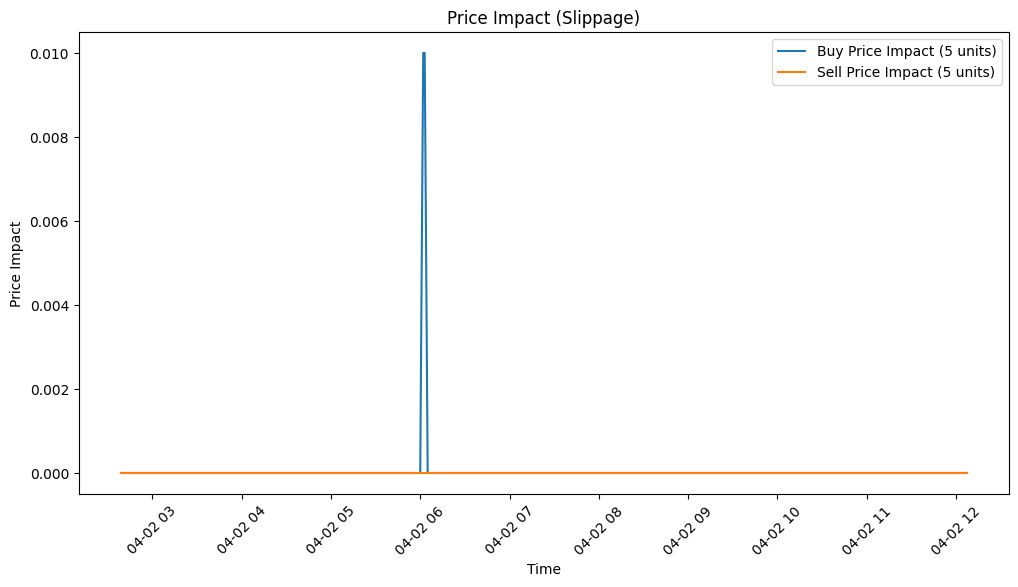

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(metrics['minute'], metrics['buy_price_impact_5'], label='Buy Price Impact (5 units)')
plt.plot(metrics['minute'], metrics['sell_price_impact_5'], label='Sell Price Impact (5 units)')
plt.title('Price Impact (Slippage)')
plt.xlabel('Time')
plt.ylabel('Price Impact')
plt.legend()
plt.xticks(rotation=45)

In [ ]:
# Ensure shares is numeric
trades['shares'] = pd.to_numeric(trades['shares'], errors='coerce')

# Discretize timestamp
trades['minute'] = pd.to_datetime(trades['block_time']).dt.floor('min')

# Separate buy/sell
buy_shares = trades[trades['action'] == 'buy'].groupby('minute')['shares'].sum().rename('buy_shares')
sell_shares = trades[trades['action'] == 'sell'].groupby('minute')['shares'].sum().rename('sell_shares')

# Merge into main metrics DataFrame
metrics = metrics.merge(buy_shares, on='minute', how='left')
metrics = metrics.merge(sell_shares, on='minute', how='left')

# Fill NaN with 0
metrics[['buy_shares', 'sell_shares']] = metrics[['buy_shares', 'sell_shares']].fillna(0)


In [ ]:
metrics

,minute,best_bid,best_ask,bid_ask_spread,total_bid_depth,total_ask_depth,top_bid_depth,top_ask_depth,order_book_imbalance,buy_price_impact_5,...,total_shares,trade_count,effective_spread,realized_spread,adverse_selection_cost,volatility_lag,volatility_clustering,vol_spread_correlation,buy_shares,sell_shares
0,2025-04-02 02:39:00,0.40,0.41,0.01,1114883.78,2260296.32,207.01,201.00,0.014730,0.0,...,207.610000,3,0.024590,0.018817,-0.013043,NaN,NaN,5.773503e-05,0.0,0.0
1,2025-04-02 02:45:00,0.40,0.41,0.01,1136480.83,2251026.24,15582.06,25949.61,-0.249630,0.0,...,64.000484,3,0.024390,0.024390,-0.024390,5.773503e-03,3.006667e-11,5.207700e-11,0.0,0.0
2,2025-04-02 02:46:00,0.40,0.41,0.01,1130989.72,2272121.02,10090.95,25934.39,-0.439786,0.0,...,5109.050000,1,0.025000,NaN,NaN,5.207700e-09,NaN,NaN,0.0,0.0
3,2025-04-02 02:47:00,0.40,0.41,0.01,1137095.98,2272623.53,11338.75,24034.39,-0.358906,0.0,...,2000.000000,1,0.024390,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2025-04-02 02:49:00,0.40,0.41,0.01,1137961.98,2283016.13,11538.75,8019.26,0.179951,0.0,...,8762.793899,3,0.024590,0.018817,-0.013043,NaN,NaN,5.773503e-05,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2025-04-02 12:00:00,0.38,0.39,0.01,908223.47,2093569.42,175969.74,3294.54,0.963244,0.0,...,6985.410255,5,0.025126,0.020653,-0.016181,5.773502e-03,2.581989e-05,4.472137e-05,0.0,0.0
201,2025-04-02 12:01:00,0.39,0.40,0.01,903818.41,2081851.88,1562.17,20701.57,-0.859667,0.0,...,1468.860000,2,0.025641,0.025641,-0.025641,4.472137e-03,3.510834e-19,7.850462e-19,0.0,0.0
202,2025-04-02 12:03:00,0.38,0.40,0.02,894084.24,2082007.29,170204.01,21784.62,0.773063,0.0,...,6495.450000,4,0.050633,0.044859,-0.039086,7.850462e-17,4.532467e-19,1.154701e-04,0.0,0.0
203,2025-04-02 12:04:00,0.38,0.40,0.02,895585.74,2087929.24,170004.01,28162.57,0.715769,0.0,...,260.000000,2,0.050000,0.050000,-0.050000,5.773503e-03,0.000000e+00,0.000000e+00,0.0,0.0


In [ ]:
fig = go.Figure()

# Raw bid-ask spread
fig.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['bid_ask_spread'],
    name='Bid-Ask Spread', line=dict(color='black')
))

# Effective spread
fig.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['effective_spread'],
    name='Effective Spread', line=dict(color='blue', dash='dash')
))

# Realized spread
fig.add_trace(go.Scatter(
    x=metrics['minute'], y=metrics['realized_spread'],
    name='Realized Spread', line=dict(color='green', dash='dot')
))

# Layout
fig.update_layout(
    title='Spread Comparison Over Time',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Spread'),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white'
)

fig.show()

In [ ]:
# --- Step 1: Prepare Order Book Data (df) ---

# Convert timestamp and normalize timezone
df['timestamp'] = pd.to_datetime(df['timestamp_human'], utc=True).dt.tz_localize(None)
df['minute'] = df['timestamp'].dt.floor('min')

# Best bid and best ask per minute
best_bid = df[df['side'] == 'bid'].groupby('minute')['price'].max().rename('best_bid')
best_ask = df[df['side'] == 'ask'].groupby('minute')['price'].min().rename('best_ask')

# Combine into mid-price DataFrame
mid_price_df = pd.concat([best_bid, best_ask], axis=1).dropna()
mid_price_df['mid_price'] = (mid_price_df['best_bid'] + mid_price_df['best_ask']) / 2
mid_price_df['mid_price_return'] = mid_price_df['mid_price'].diff()

# --- Step 2: Prepare Trades Data (trades) ---

# Convert timestamp and normalize timezone
trades['block_time'] = pd.to_datetime(trades['block_time'], utc=True).dt.tz_localize(None)
trades['minute'] = trades['block_time'].dt.floor('min')

# Compute signed volume
trades['signed_volume'] = np.where(trades['action'] == 'buy', trades['amount'], -trades['amount'])

# Aggregate signed volume per minute
signed_volume_df = trades.groupby('minute')['signed_volume'].sum().rename('signed_volume')

# --- Step 3: Merge and Estimate Kyle's Lambda ---

# Merge mid-price returns and signed volume
kyle_df = pd.merge(mid_price_df, signed_volume_df, left_index=True, right_index=True)
kyle_df = kyle_df.dropna(subset=['mid_price_return', 'signed_volume'])

# Estimate Kyle's Lambda
cov = np.cov(kyle_df['mid_price_return'], kyle_df['signed_volume'])[0, 1]
var = np.var(kyle_df['signed_volume'])
kyles_lambda = cov / var

print(f"📊 Kyle's Lambda: {kyles_lambda:.6f}")

# --- Step 4: Visualize ---

fig = px.scatter(
    kyle_df,
    x='signed_volume',
    y='mid_price_return',
    trendline='ols',
    title="Kyle's Lambda Estimation (Mid-Price Return vs Signed Volume)",
    labels={'signed_volume': 'Signed Volume', 'mid_price_return': 'Mid-Price Return'}
)
fig.show()

📊 Kyle's Lambda: 0.000000


In [ ]:
!pip install -q jupyter-dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.8 MB/s eta 0:00:00


In [ ]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# --- Simulated example data (replace with your actual metrics) ---
minutes = pd.date_range('2025-01-01', periods=100, freq='T')
example_df = pd.DataFrame({
    'minute': minutes,
    'buy_price_impact_5': np.random.rand(100) * 0.05,
    'sell_price_impact_5': np.random.rand(100) * 0.05,
})

def compute_single_market_metrics(order_book, trade_data, order_size):
    # Simulated slippage calculation — replace with your real function
    df = example_df.copy()
    df[f'buy_price_impact_{order_size}'] = df['buy_price_impact_5'] * (order_size / 5)
    df[f'sell_price_impact_{order_size}'] = df['sell_price_impact_5'] * (order_size / 5)
    return df

# --- Build dashboard ---
order_book = None  # Your actual order book DataFrame
trade_data = None  # Your actual trades DataFrame
initial_order_size = 5
metrics = compute_single_market_metrics(order_book, trade_data, order_size=initial_order_size)

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H3("Slippage (Price Impact) Over Time"),
    dcc.Slider(
        id='order-size-slider',
        min=1, max=50, step=1, value=initial_order_size,
        marks={i: str(i) for i in range(1, 51, 5)}
    ),
    dcc.Graph(id='slippage-graph')
])

@app.callback(
    Output('slippage-graph', 'figure'),
    Input('order-size-slider', 'value')
)
def update_graph(order_size):
    updated = compute_single_market_metrics(order_book, trade_data, order_size)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=updated['minute'], y=updated[f'buy_price_impact_{order_size}'],
                             name='Buy Price Impact', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=updated['minute'], y=updated[f'sell_price_impact_{order_size}'],
                             name='Sell Price Impact', line=dict(color='red', dash='dot')))
    fig.update_layout(title=f'Slippage for Order Size = {order_size}',
                      xaxis_title='Time', yaxis_title='Price Impact',
                      template='plotly_white')
    return fig

# ✅ Use JupyterDash's inline mode (this is the part that avoids the `super` error!)
app.run_server(mode='inline')


AttributeError: 'super' object has no attribute 'run_server'

In [ ]:
!pip install --upgrade plotly dash jupyter-dash

    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [63]:
df

,market,asset_id,timestamp,side,price,size,timestamp_human,market_id,minute
0,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.01,115516.12,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 02:39:00
1,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.02,225422.00,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 02:39:00
2,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.04,2996.80,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 02:39:00
3,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.05,5755.00,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 02:39:00
4,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 02:39:01,bid,0.10,83039.21,2025-04-02 02:39:01,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 02:39:00
...,...,...,...,...,...,...,...,...,...
41963,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 12:15:07,ask,0.43,124453.86,2025-04-02 12:15:07,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 12:15:00
41964,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 12:15:07,ask,0.42,129860.37,2025-04-02 12:15:07,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 12:15:00
41965,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 12:15:07,ask,0.41,19025.97,2025-04-02 12:15:07,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 12:15:00
41966,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,4051215372614097934996293646314189817943778807...,2025-04-02 12:15:07,ask,0.40,31309.83,2025-04-02 12:15:07,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,2025-04-02 12:15:00


In [33]:
trades

,block_number,block_time,tx_hash,evt_index,action,contract_address,condition_id,event_market_name,question,polymarket_link,...,asset_id,price,amount,shares,fee,maker,taker,unique_key,token_outcome_name,minute
0,69798220.0,2025-04-02 08:26:03+00:00,0x641e7cdd916175f1fa0be7e283ea96b48727d06d31cf...,569,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.410000,0.764406,1.864404,0,0xcfed54e9e04ad3e556bf87a918aac31c71dedf12,0xe47c4106342b732470466dab2455326eef9d6e9a,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 08:26:00+00:00
1,69802370.0,2025-04-02 10:53:05+00:00,0x8e282de5f70548396f69ce7fe3472c7f426dee96ac85...,206,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,70.000000,175.000000,0,0x843a6da3886cf889435cf0920659a00a68db8070,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:53:00+00:00
2,69793316.0,2025-04-02 05:32:11+00:00,0xf25e1de4fef372b1e5af73970795070f19a7b47b896f...,169,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.410000,261.170000,637.000000,0,0x15b2a08ee0d4c87b54501f82ef4de2ac9eb62f77,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 05:32:00+00:00
3,69802298.0,2025-04-02 10:50:31+00:00,0x486b8686a57684b2f03bc1ec14ac11fe6ef006226316...,403,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,400.000000,1000.000000,0,0x96e0c92ef3e4e9293a1f64c0ad7b75116ad2b648,0xe2e3c801656a73b2bfd88a41bcf9226d53be67ff,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:50:00+00:00
4,69791260.0,2025-04-02 04:19:12+00:00,0x02cd9006189081932fc9d18ed109f068584e6e2d3792...,293,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.401395,1999.999999,4982.621218,0,0xa847eed644251444364e9587086de7e102fa88a5,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 04:19:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,69801106.0,2025-04-02 10:08:19+00:00,0xb12e0be44b7cf351c6be9e261e8196873519d0b00513...,575,CLOB trade,0x4bfb41d5b3570defd03c39a9a4d8de6bd8b8982e,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,single market,Yoon out as president of South Korea before May?,<a href='https://polymarket.com/event/yoon-out...,...,4051215372614097934996293646314189817943778807...,0.400000,2000.000000,5000.000000,0,0xa0e72c4d3d779078f6bd7bd2670ecdc1829bef20,0x0c8f308a923218bb83ee2c5d6aebfaeeaefe44f0,0x6b24a578e8644f45e49130da20267e466163dc35fee3...,No-Yoon out as president of South Korea before...,2025-04-02 10:08:00+00:00
455,69794674.0,2025-04-02 06:20:21+00:00,0xd165

In [133]:
class Market:
    def __init__(self, order_book, trades, order_size=5, start_time=None, end_time=None, timestep="1min", market_id=None, token_id=None):
        self.raw_order_book = order_book.copy()
        self.raw_trades = trades.copy()
        self.order_size = order_size
        self.start_time = pd.to_datetime(start_time) if start_time else pd.concat([order_book['minute'], trades['minute']]).min()
        self.end_time = pd.to_datetime(end_time) if end_time else pd.concat([order_book['minute'], trades['minute']]).max()
        self.timestep = timestep
        self.market_id = market_id if market_id else trades['market_id'].iloc[0] if 'market_id' in trades.columns else None
        self.token_id = token_id if token_id else trades['asset_id'].iloc[0] if 'asset_id' in trades.columns else None
        self.token_outcome_name = trades['token_outcome_name'].iloc[0] if 'token_outcome_name' in trades.columns else None

        order_book['minute'] = pd.to_datetime(order_book['minute']).dt.tz_localize(None)
        trades['minute'] = pd.to_datetime(trades['minute']).dt.tz_localize(None)

        self.order_book = None
        self.trades = None
        self.metrics_df = None

        self._preprocess()

    def _preprocess(self):
        def preprocess_order_book(df):
            df['timestamp'] = pd.to_datetime(df['timestamp_human'], utc=True).dt.tz_localize(None)
            df['minute'] = df['timestamp'].dt.floor('min')
            df['price'] = pd.to_numeric(df['price'], errors='coerce')
            df['size'] = pd.to_numeric(df['size'], errors='coerce')
            return df

        def preprocess_trades(df):
            df['block_time'] = pd.to_datetime(df['block_time'], utc=True).dt.tz_localize(None)
            df['minute'] = df['block_time'].dt.floor('min')
            df['price'] = pd.to_numeric(df['price'], errors='coerce')
            df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
            df['shares'] = pd.to_numeric(df['shares'], errors='coerce')
            df['signed_volume'] = df.apply(lambda r: r['amount'] if r['action'] == 'buy' else -r['amount'], axis=1)
            return df

        self.order_book = preprocess_order_book(self.raw_order_book)
        self.trades = preprocess_trades(self.raw_trades)
        if self.start_time:
            self.order_book = self.order_book[self.order_book['minute'] >= self.start_time]
            self.trades = self.trades[self.trades['minute'] >= self.start_time]
        if self.end_time:
            self.order_book = self.order_book[self.order_book['minute'] <= self.end_time]
            self.trades = self.trades[self.trades['minute'] <= self.end_time]
        self.order_book['minute'] = self.order_book['minute'].dt.floor(self.timestep)
        self.trades['minute'] = self.trades['minute'].dt.floor(self.timestep)

    def compute_all_metrics(self):
        metrics = []

        for minute, group in self.order_book.groupby('minute'):
            bids = group[group['side'] == 'bid'].sort_values('price', ascending=False)
            asks = group[group['side'] == 'ask'].sort_values('price', ascending=True)

            best_bid = bids['price'].iloc[0] if not bids.empty else np.nan
            best_ask = asks['price'].iloc[0] if not asks.empty else np.nan
            spread = best_ask - best_bid if pd.notna(best_bid) and pd.notna(best_ask) else np.nan

            total_bid_depth = bids['size'].sum()
            total_ask_depth = asks['size'].sum()

            top_bid_depth = bids['size'].iloc[0] if not bids.empty else 0
            top_ask_depth = asks['size'].iloc[0] if not asks.empty else 0

            imbalance = (top_bid_depth - top_ask_depth) / (top_bid_depth + top_ask_depth) if (top_bid_depth + top_ask_depth) > 0 else np.nan

            def price_impact(book_side):
                cumulative = 0
                for _, row in book_side.iterrows():
                    cumulative += row['size']
                    if cumulative >= self.order_size:
                        return abs(row['price'] - book_side.iloc[0]['price'])
                return np.nan

            buy_impact = price_impact(asks)
            sell_impact = price_impact(bids)

            metrics.append({
                'minute': minute,
                'best_bid': best_bid,
                'best_ask': best_ask,
                'bid_ask_spread': spread,
                'total_bid_depth': total_bid_depth,
                'total_ask_depth': total_ask_depth,
                'top_bid_depth': top_bid_depth,
                'top_ask_depth': top_ask_depth,
                'order_book_imbalance': imbalance,
                f'buy_price_impact_{self.order_size}': buy_impact,
                f'sell_price_impact_{self.order_size}': sell_impact,
            })

        order_metrics = pd.DataFrame(metrics)

        trade_metrics = self.trades.groupby('minute').agg(
            avg_price=('price', 'mean'),
            realized_volatility=('price', 'std'),
            total_volume=('amount', 'sum'),
            total_shares=('shares', 'sum'),
            trade_count=('price', 'count')
        ).reset_index()

        combined = pd.merge(order_metrics, trade_metrics, on='minute', how='inner')

        combined['effective_spread'] = combined['bid_ask_spread'] / combined['avg_price']
        combined['realized_spread'] = combined['effective_spread'] - combined['realized_volatility']
        combined['adverse_selection_cost'] = combined['realized_volatility'] - combined['realized_spread']

        combined['volatility_lag'] = combined['realized_volatility'].shift(1)
        combined['volatility_clustering'] = combined['realized_volatility'] * combined['volatility_lag']

        combined['vol_spread_correlation'] = combined['realized_volatility'] * combined['bid_ask_spread']

        self.metrics_df = combined
        return combined

    @property
    def bid_ask_spread(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'bid_ask_spread']].dropna().reset_index(drop=True)

    @property
    def top_of_book_depth(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'top_bid_depth', 'top_ask_depth']].dropna().reset_index(drop=True)

    @property
    def order_book_imbalance(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'order_book_imbalance']].dropna().reset_index(drop=True)

    @property
    def price_impact(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', f'buy_price_impact_{self.order_size}', f'sell_price_impact_{self.order_size}']].dropna().reset_index(drop=True)

    @property
    def effective_spread(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'effective_spread']].dropna().reset_index(drop=True)

    @property
    def realized_spread(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'realized_spread']].dropna().reset_index(drop=True)

    @property
    def adverse_selection_cost(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'adverse_selection_cost']].dropna().reset_index(drop=True)

    @property
    def realized_volatility(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'realized_volatility']].dropna().reset_index(drop=True)

    @property
    def volatility_clustering(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'volatility_clustering']].dropna().reset_index(drop=True)

    @property
    def vol_spread_correlation(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        return self.metrics_df[['minute', 'vol_spread_correlation']].dropna().reset_index(drop=True)

    def liquidity_score(self):
        if self.metrics_df is None:
            self.compute_all_metrics()
        df = self.metrics_df.copy()
        df['liquidity_score'] = (df['total_bid_depth'] + df['total_ask_depth']) * df['trade_count'] / (1 + df['total_volume'])
        df['liquidity_score'] = 100 * df['liquidity_score'] / df['liquidity_score'].max()
        return df[['minute', 'liquidity_score']].dropna().reset_index(drop=True)

    def plot_liquidity_score(self):
        import plotly.graph_objects as go
        import pandas as pd

        df = self.liquidity_score()
        df = df.merge(self.realized_volatility, on='minute', how='left')
        df = df.merge(self.metrics_df[['minute', 'total_volume', 'order_book_imbalance']], on='minute', how='left')
        df['smoothed_liquidity'] = df['liquidity_score'].rolling(window=5, min_periods=1).mean()

        fig = go.Figure()

        # Liquidity Score (main line)
        fig.add_trace(go.Scatter(
            x=df['minute'], y=df['liquidity_score'], name='Liquidity Score',
            line=dict(color='blue'), opacity=0.5
        ))

        # Smoothed Line
        fig.add_trace(go.Scatter(
            x=df['minute'], y=df['smoothed_liquidity'], name='Smoothed Liquidity',
            line=dict(color='blue', dash='dot')
        ))

        # Realized Volatility
        fig.add_trace(go.Scatter(
            x=df['minute'], y=df['realized_volatility'], name='Realized Volatility',
            yaxis='y2', line=dict(color='orange')
        ))

        # Volume Bars
        fig.add_trace(go.Bar(
            x=df['minute'], y=df['total_volume'], name='Volume', yaxis='y3', opacity=0.2,
            marker_color='grey'
        ))

        # Layout
        fig.update_layout(
            title='Liquidity Score with Volatility and Volume',
            xaxis=dict(title='Time'),
            yaxis=dict(title='Liquidity Score (0-100)', side='left'),
            yaxis2=dict(title='Volatility', overlaying='y', side='right', anchor='x'),
            yaxis3=dict(title='Volume', overlaying='y', side='right', anchor='free', position=1.0),
            legend=dict(x=0.01, y=0.99),
            barmode='overlay',
            height=600
        )

        fig.show()

    def plot_all_metric_groups(self):
        import plotly.graph_objects as go

        # --- Market Quality ---
        fig1 = go.Figure()
        fig1.add_trace(go.Scatter(x=self.effective_spread['minute'], y=self.effective_spread['effective_spread'], name='Effective Spread'))
        fig1.add_trace(go.Scatter(x=self.realized_spread['minute'], y=self.realized_spread['realized_spread'], name='Realized Spread'))
        fig1.add_trace(go.Scatter(x=self.bid_ask_spread['minute'], y=self.bid_ask_spread['bid_ask_spread'], name='Bid-Ask Spread'))
        fig1.update_layout(title='Market Quality Metrics', xaxis_title='Time', yaxis_title='Spread')
        fig1.show()

        # --- Volatility & Clustering ---
        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(x=self.realized_volatility['minute'], y=self.realized_volatility['realized_volatility'], name='Volatility'))
        fig2.add_trace(go.Scatter(x=self.volatility_clustering['minute'], y=self.volatility_clustering['volatility_clustering'], name='Clustering'))
        fig2.update_layout(title='Volatility & Clustering', xaxis_title='Time', yaxis_title='Volatility')
        fig2.show()

        # --- LP Cost Breakdown ---
        fig3 = go.Figure()
        fig3.add_trace(go.Scatter(x=self.realized_spread['minute'], y=self.realized_spread['realized_spread'], name='Realized Spread'))
        fig3.add_trace(go.Scatter(x=self.adverse_selection_cost['minute'], y=self.adverse_selection_cost['adverse_selection_cost'], name='Adverse Selection'))
        fig3.update_layout(title='Liquidity Provider Cost Breakdown', xaxis_title='Time', yaxis_title='Cost')
        fig3.show()

        # --- Imbalance & Vol-Spread ---
        fig4 = go.Figure()
        fig4.add_trace(go.Scatter(x=self.order_book_imbalance['minute'], y=self.order_book_imbalance['order_book_imbalance'], name='Order Book Imbalance'))
        fig4.add_trace(go.Scatter(x=self.vol_spread_correlation['minute'], y=self.vol_spread_correlation['vol_spread_correlation'], name='Vol-Spread Correlation'))
        fig4.update_layout(title='Imbalance & Spread Sensitivity to Volatility', xaxis_title='Time', yaxis_title='Metric')
        fig4.show()


        return f"<Market id={self.market_id}, token_id={self.token_id}, outcome={self.token_outcome_name}, range=({self.start_time}, {self.end_time}), timestep={self.timestep}>"

In [134]:
m = Market(df, trades)

In [135]:
m.plot_liquidity_score()

In [130]:
m.plot_all_metric_groups()

'<Market id=None, token_id=40512153726140979349962936463141898179437788077397702575621092542561027021417, outcome=No-Yoon out as president of South Korea before May?, range=(2025-04-02 02:39:00, 2025-04-02 12:15:00), timestep=1min>'

In [34]:
# Convert timestamps and discretize by minute
trades['timestamp'] = trades['block_time']
df['timestamp'] = pd.to_datetime(df['timestamp_human'])
df['minute'] = df['timestamp'].dt.floor('min')

trades['block_time'] = pd.to_datetime(trades['block_time'])
trades['minute'] = trades['block_time'].dt.floor('min')

# Ensure numeric types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')
trades['price'] = pd.to_numeric(trades['price'], errors='coerce')
trades['amount'] = pd.to_numeric(trades['amount'], errors='coerce')
trades['shares'] = pd.to_numeric(trades['shares'], errors='coerce')  # ✅ New line for shares

# Drop NA and filter required columns
order_book = df[['minute', 'side', 'price', 'size']].dropna()
trade_data = trades[['minute', 'price', 'amount', 'shares']].dropna()

In [36]:
order_book

,minute,side,price,size
0,2025-04-02 02:39:00,bid,0.01,115516.12
1,2025-04-02 02:39:00,bid,0.02,225422.00
2,2025-04-02 02:39:00,bid,0.04,2996.80
3,2025-04-02 02:39:00,bid,0.05,5755.00
4,2025-04-02 02:39:00,bid,0.10,83039.21
...,...,...,...,...
41963,2025-04-02 12:15:00,ask,0.43,124453.86
41964,2025-04-02 12:15:00,ask,0.42,129860.37
41965,2025-04-02 12:15:00,ask,0.41,19025.97
41966,2025-04-02 12:15:00,ask,0.40,31309.83


In [102]:
m = Market(df, trades)

In [113]:
m.o

Timestamp('2025-04-02 02:39:00')

In [118]:
m.top_of_book_depth

,minute,top_bid_depth,top_ask_depth
0,2025-04-02 02:39:00,207.01,201.00
1,2025-04-02 02:45:00,15582.06,25949.61
2,2025-04-02 02:46:00,10090.95,25934.39
3,2025-04-02 02:47:00,11338.75,24034.39
4,2025-04-02 02:49:00,11538.75,8019.26
...,...,...,...
200,2025-04-02 12:00:00,175969.74,3294.54
201,2025-04-02 12:01:00,1562.17,20701.57
202,2025-04-02 12:03:00,170204.01,21784.62
203,2025-04-02 12:04:00,170004.01,28162.57


In [111]:
import plotly.express as px

,minute,realized_volatility
0,2025-04-02 02:39:00,5.773503e-03
1,2025-04-02 02:45:00,5.207700e-09
2,2025-04-02 02:49:00,5.773503e-03
3,2025-04-02 02:50:00,5.773503e-03
4,2025-04-02 02:52:00,0.000000e+00
...,...,...
84,2025-04-02 11:59:00,5.773502e-03
85,2025-04-02 12:00:00,4.472137e-03
86,2025-04-02 12:01:00,7.850462e-17
87,2025-04-02 12:03:00,5.773503e-03


In [ ]:
fig = px.line(
    m.order_book_imbalance,
    x="minute",
    y="order_book_imbalance",
    title="order_book_imbalance Over Time",
    labels={"minute": "Time", "order_book_imbalance": "Spread"}
)
fig.show()

In [117]:
fig = px.line(
    m.order_book_imbalance,
    x="minute",
    y="order_book_imbalance",
    title="order_book_imbalance Over Time",
    labels={"minute": "Time", "order_book_imbalance": "Spread"}
)
fig.show()

In [121]:
import plotly.graph_objects as go

fig = go.Figure()

# Bid-Ask Spread (left y-axis)
fig.add_trace(go.Scatter(
    x=m.bid_ask_spread['minute'],
    y=m.bid_ask_spread['bid_ask_spread'],
    name="Bid-Ask Spread",
    yaxis="y1"
))

# Top-of-Book Depth (right y-axis)
fig.add_trace(go.Scatter(
    x=m.top_of_book_depth['minute'],
    y=m.top_of_book_depth['top_bid_depth'],
    name="Top Bid Depth",
    yaxis="y2",
    #line=dict(dash="dash")
))
fig.add_trace(go.Scatter(
    x=m.top_of_book_depth['minute'],
    y=m.top_of_book_depth['top_ask_depth'],
    name="Top Ask Depth",
    yaxis="y2",
    #line=dict(dash="dot")
))

# Layout
fig.update_layout(
    title="Bid-Ask Spread and Top-of-Book Depth Over Time",
    xaxis=dict(title="Time"),
    yaxis=dict(title="Bid-Ask Spread", side="left"),
    yaxis2=dict(title="Top-of-Book Depth", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99)
)

fig.show()